#**CLASSIFICATION : TRUE VS FALSE VS OTHER VS MIXTURE:**

**Membres:** Hadjoudja Bachir (21811363), Zeggar Rym (21909615), Bendahmane Rania (21811387), Labiad Youcef (21710780).

In [ ]:
import sys
import pandas as pd
import numpy as np 
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
import re
import pickle
import string
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import vstack
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss
from torch.optim import SGD
from torch.nn.init import kaiming_uniform_, xavier_uniform_


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive
%ls

%pwd

/content/gdrive/My Drive/Colab Notebooks
 bonFakeNEWS4.ipynb
'BON_TRUE FALSE_vs_OTHER_entités_nommées.ipynb'
'Copie de FakeNEWS.ipynb'
'Copie de True_False_Other_Mixture.ipynb'
'Copie de TRUE FALSE_vs_OTHER_entités_nommées.ipynb'
'Copie de  Vrai_Faux._entites_marche_bien.ipynb'
 FakeNewsLastVersion.ipynb
 ml_entiteesNommeesTest.ipynb
'Traitement sémantique'/
 True_False_Other_Mixture_final.ipynb
 Untitled0.ipynb
 version2ml_entiteesNommeesTest.ipynb
'VRAI FAUX OTHER MIXTURE_avec_entites_nommees.ipynb'


'/content/gdrive/My Drive/Colab Notebooks'

La fonction qui sera utilisée pour les prétraitements: MyCleanText 
* Mettre le texte en minuscule
* Se débarasser des stopwords
* Se débarasser des nombres
* Stemmatisation
* Lemmatisation ..

In [ ]:
#...................................................Fonction MyCleanText .............................................................................
# mettre en minuscule
#enlever les stopwords
#se debarasser des nombres
#stemmatisation
#lemmatisation 
#......................................................................................................................................................


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
#liste des stopwords en anglais
stop_words = set(stopwords.words('english')) 

def MyCleanText(X,
                lowercase=False, #mettre en minuscule
                removestopwords=False, #supprimer les stopwords
                removedigit=False, #supprimer les nombres
                getstemmer=False, #conserver la racine des termes
                getlemmatisation=False #lemmatisation des termes
                ):
  #conversion du texte d'entrée en chaîne de caractères
    sentence=str(X)
    #suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence   

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


* La classe TextNormalizer qui contiendra la fonction MyCleanText.

* Fit_transform de mon corpus propre.

In [ ]:
#..................................................Etape 1 : prétraitement du texte ...................................................................................................
#...................................................Fonction TextNormalizer  .............................................................................
#fit_transform de mon corpus propre 
#......................................................................................................................................................

from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self    


* La fonction MyShowAllScores prend en entrée y_test et y_predict et affiche la classification report et la matrice de confusion

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
# fonction qui affiche le classification report et la matrice de confusion
from sklearn import metrics
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import classification_report



def MyshowAllScores(y_test,y_pred):
  classes= np.unique(y_test)
  print("Accuracy : %0.3f"%(accuracy_score(y_test,y_pred)))
  print("Classification Report")
  print(classification_report(y_test,y_pred,digits=5))    
  cnf_matrix = confusion_matrix(y_test,y_pred)
  disp=ConfusionMatrixDisplay(cnf_matrix,display_labels=classes)
  disp.plot()



##**True/False VS Mixture/OTHER**

###**Etape 1 : Préparer les données**
* Load et preparer les données à partir des 2 fichiers csv
* Sélectionner que les lignes où on a True ou False et les lignes où on a other ou mixture en sortie.
* Après en créant une nouvelle colonne "regrouped" si la valeur de la colonne rating est true ou bien false on mettra TRUE/FALSE sinon on mettra MIXTURE/OTHER

In [ ]:
dftrain1 = pd.read_csv("/content/gdrive/MyDrive/newsTrain2.csv", names=['id','text','title','rating'], header=0,sep=',', encoding='utf8')
dftrain1.reset_index(drop = True, inplace = True)

dftrain2 = pd.read_csv("/content/gdrive/MyDrive/projet_ML/newsTrain - newsTrain.csv", names=['id','text','title','rating'], header=0,sep=',', encoding='utf8')
dftrain2.reset_index(drop = True, inplace = True)


# concaténer les deux dataframes en ajoutant les lignes du deuxième à la fin du premier
dftrainbase = pd.concat([dftrain1, dftrain2], ignore_index=True)
dftrain=dftrainbase

#On crée une colonne regroupe qui va mettre dans les lignes là où a true ou bien false la valeur TRUE/FALSE et OTHER ça laisse
#dftrain['truefalse'] = dftrain['rating'].apply(lambda x: 'TRUE/FALSE' if x in ['TRUE', 'FALSE'] else '')
#On crée une colonne regroupe qui va mettre dans les lignes là où a true ou bien false la valeur TRUE/FALSE et OTHER ça laisse
#dftrain['mixtureother'] = dftrain['rating'].apply(lambda x:'MIXTURE/OTHER' if x in ['MIXTURE', 'OTHER'] else '')

dftrain['regrouped'] = dftrain['rating'].apply(lambda x:'TRUE/FALSE' if x in ['TRUE', 'FALSE'] else 'MIXTURE/OTHER')



print("Echantillon de mon dataset \n")
print(dftrain.sample(n=10))
print("\n")
print("Quelques informations importantes \n")
dftrain.info()
print("\n")
X_text=dftrain["text"]
X_title=dftrain["title"]


print("le texte est")
display(X_text)
print("\n")
print("le titre est")
display(X_title)
print("\n")
y=dftrain.iloc[0:,-1]
print("voici la dernière case de rating")
display(y)
print("\n")
print("la taille de Xt est",X_text.shape)
print("\n")
print(" y EST " ,y)
print("\n")
y = y.str.lower()
print("Les valeurs de true et false sont:\n", y.value_counts())


Echantillon de mon dataset 

            id                                               text  \
1512  6130328a  After the Korean Medical Association had calle...   
1825  0192a5cc  The shooting of 18-year-old Michael Brown is a...   
933   8fba8857  In a scenario straight out of “The Twilight Zo...   
733   c5a4ee2d  If you needed any more proof that the migrant ...   
1152  ea647a18  The number of children and teenagers needing s...   
835   996025bf  WASHINGTON (AP) _ Canadian-born quiz show host...   
1053  246c4405  A report by the National Audit Office has said...   
9     f2182a54  FEMA camps, portable human cages, it's all rea...   
2513  3d1a155a  There is nothing we can do about it, except to...   
1358  cbb6ee95  Equally troubling was the more recent discover...   

                                                  title   rating  \
1512  Flu Vaccine Deaths in South Korea risen to nea...  mixture   
1825         Rand Paul: We Must Demilitarize the Police     TRUE   
933   C

0       Distracted driving causes more deaths in Canad...
1       Missouri politicians have made statements afte...
2       Home Alone 2: Lost in New York is full of viol...
3       But things took a turn for the worse when riot...
4       It’s no secret that Epstein and Schiff share a...
                              ...                        
2523    More than four million calls to the taxman are...
2524    More under-18s are being taken to court for se...
2525    The Government’s much vaunted Help to Buy Isa ...
2526    The late Robin Williams once called cocaine “G...
2527    The late Robin Williams once called cocaine “G...
Name: text, Length: 2528, dtype: object



le titre est


0       You Can Be Fined $1,500 If Your Passenger Is U...
1           Missouri lawmakers condemn Las Vegas shooting
2       CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...
3       Obama’s Daughters Caught on Camera Burning US ...
4       Leaked Visitor Logs Reveal Schiff’s 78 Visits ...
                              ...                        
2523    Taxman fails to answer four million calls a ye...
2524    Police catch 11‑year‑olds being used to sell d...
2525    Help to Buy Isa scandal: 500,000 first-time bu...
2526             A coke-snorting generation of hypocrites
2527             A coke-snorting generation of hypocrites
Name: title, Length: 2528, dtype: object



voici la dernière case de rating


0          TRUE/FALSE
1       MIXTURE/OTHER
2       MIXTURE/OTHER
3          TRUE/FALSE
4          TRUE/FALSE
            ...      
2523       TRUE/FALSE
2524       TRUE/FALSE
2525       TRUE/FALSE
2526       TRUE/FALSE
2527       TRUE/FALSE
Name: regrouped, Length: 2528, dtype: object



la taille de Xt est (2528,)


 y EST  0          TRUE/FALSE
1       MIXTURE/OTHER
2       MIXTURE/OTHER
3          TRUE/FALSE
4          TRUE/FALSE
            ...      
2523       TRUE/FALSE
2524       TRUE/FALSE
2525       TRUE/FALSE
2526       TRUE/FALSE
2527       TRUE/FALSE
Name: regrouped, Length: 2528, dtype: object


Les valeurs de true et false sont:
 true/false       1578
mixture/other     950
Name: regrouped, dtype: int64


Le jeu de données étant déséquilibré, on a pensé à appliquer le downsampling pour équilibrer nos données. on séléctionne des lignes aléatoirement de TRUE/FALSE de telle sorte que le nombre de lignes de TRUE/FALSE soit = au nbr de lignes de Other/Mixture. et on mélange le DataFrame.

In [ ]:
#On applique du sous-échantillonnage (downsampling) : car on a plus de FALSE (578) que des TRUE (211) 

# Séparer les classes en deux dataframes
df_false_true = dftrain[dftrain['regrouped'] == 'TRUE/FALSE']
df_other_mixture = dftrain [dftrain['regrouped'] == 'MIXTURE/OTHER']

# Sous-échantillonner la classe majoritaire (FALSE) pour obtenir un nombre égal d'échantillons pour chaque classe
df_subsampled = df_false_true.sample(n=len(df_other_mixture), random_state=42)

# Concaténer les deux dataframes
dftrain = pd.concat([df_subsampled, df_other_mixture])

# Mélanger aléatoirement les données
dftrain = dftrain.sample(frac=1, random_state=42)

X_text=dftrain.iloc[0:,1:2]
X_title=dftrain.iloc[0:,2:3]

print("le texte est")
display(X_text)
print("le titre est")
display(X_title)

y=dftrain.iloc[0:,-1]
print("le y est")
display(y)
print("la taille de X_text est",X_text.shape)
print("la taille de y_train est " ,y.shape)
print("les valeurs de TRUE et FALSE maintenant sont " ,y.value_counts())

le texte est


,text
847,Also on the naughty list were Christmas carols...
447,The number of people applying for UK universit...
2243,"Unvaccinated Children Pose No Risk To Anyone, ..."
1202,Australia’s Great Barrier Reef has worst coral...
1059,One in ten patients admitted to hospital are s...
...,...
637,As Democrats basked in the glory of their take...
1022,HON. STEFAN I. MYCHAJLIW ERIE COUNTY COMPTROLL...
1515,We’ve reported on numerous events identified i...
1432,"The 2021 Act on Climate, legislation sponsored..."


le titre est


,title
847,Principal banned candy canes because 'J' shape...
447,On the Capitol: Part-time pay for part-time Le...
2243,One of the strengths–and weaknesses–of a Weste...
1202,Australia’s Great Barrier Reef has worst coral...
1059,"Hospitals deluged by 5,000 diabetics a DAY: On..."
...,...
637,UK inflation soars to two-year high
1022,NaN
1515,BREAKING EXCLUSIVE: System ‘Glitch’ Also Uncov...
1432,State of Rhode Island General Assembly


le y est


847     MIXTURE/OTHER
447        TRUE/FALSE
2243       TRUE/FALSE
1202       TRUE/FALSE
1059    MIXTURE/OTHER
            ...      
637     MIXTURE/OTHER
1022    MIXTURE/OTHER
1515       TRUE/FALSE
1432    MIXTURE/OTHER
628     MIXTURE/OTHER
Name: regrouped, Length: 1900, dtype: object

la taille de X_text est (1900, 1)
la taille de y_train est  (1900,)
les valeurs de TRUE et FALSE maintenant sont  MIXTURE/OTHER    950
TRUE/FALSE       950
Name: regrouped, dtype: int64


On divise notre grand X en jeu de données d'apprentissage et de test (20% de test).

In [ ]:

X=dftrain.iloc[0:, 1:3]
print(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=8)
print("X_train is",X_train)
print("y_train is",y_train)
print("X_test is",X_test)
print("y_test is",y_test)


                                                   text  \
847   Also on the naughty list were Christmas carols...   
447   The number of people applying for UK universit...   
2243  Unvaccinated Children Pose No Risk To Anyone, ...   
1202  Australia’s Great Barrier Reef has worst coral...   
1059  One in ten patients admitted to hospital are s...   
...                                                 ...   
637   As Democrats basked in the glory of their take...   
1022  HON. STEFAN I. MYCHAJLIW ERIE COUNTY COMPTROLL...   
1515  We’ve reported on numerous events identified i...   
1432  The 2021 Act on Climate, legislation sponsored...   
628   Antibody tests support what’s been obvious: Co...   

                                                  title  
847   Principal banned candy canes because 'J' shape...  
447   On the Capitol: Part-time pay for part-time Le...  
2243  One of the strengths–and weaknesses–of a Weste...  
1202  Australia’s Great Barrier Reef has worst coral...  
1

###**Etape 2 : Classification selon la colonne TEXT :**


Tester avec plusieurs classifieurs classiques.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import time
import numpy as np

# Utilisez la méthode ravel() pour transformer y_train en un tableau unidimensionnel
#X_train = np.ravel(X_train)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
np.random.seed(42)  # Set the random seed for NumPy

score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC(random_state=42)))

# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))
    #pipeline.fit(X_train,y_train)
all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train['title'],y_train, cv=kfold, scoring=score)
    #print("Pour le classifieur",p[0],"on a un score de",cv_results.mean(),"et un écart type de",cv_results.std())
    scores.append(cv_results)
    names.append(p[0])

    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()


print("all resultats", all_results)

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))

X_train (1520, 2)
y_train (1520,)
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC(random_state=42))])
all resultats [('MultinomialNB', 0.8171052631578947, 0.022561089736160823), ('LogisticRegression', 0.8039473684210527, 0.03286841

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

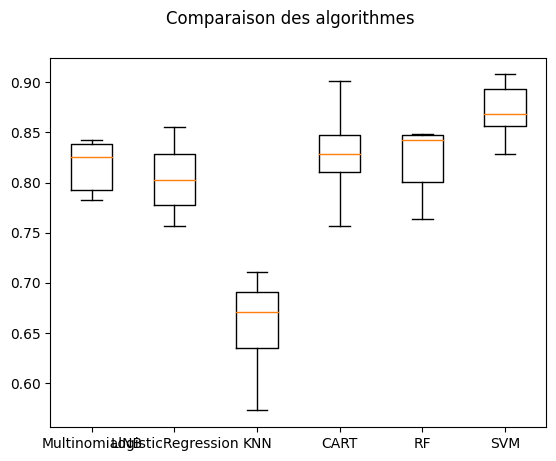

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

#### Choisir les meilleurs paramètres et hyperparamètres pour SVM, RF et LR : 



On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

y_train (1520,)
y_test (380,)
X_test (380, 2)
grid search fait
X_train (1520, 6968)
y_train (1520,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.857 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.863
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.85393   0.85393   0.85393       178
   TRUE/FALSE    0.87129   0.87129   0.87129       202

     accuracy                        0.86316       380
    macro avg    0.86261   0.86261   0.86261       380
 weighted avg    0.86316   0.86316   0.86316       380

Ensemble des meilleurs paramètres :
	C: 1
	gamma: 'scale'
	kernel: 'rbf'
grid search fait
X_train (1520, 6837)
y_train (1520,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.857 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.879
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.87079   0.87079   0.87079

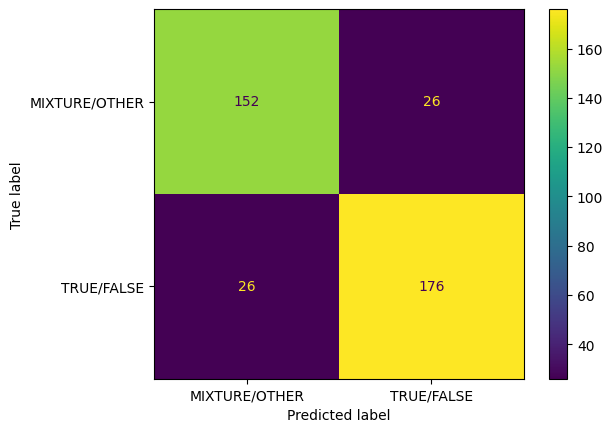

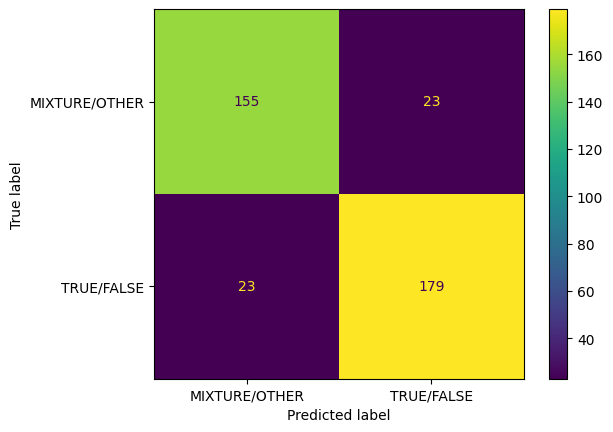

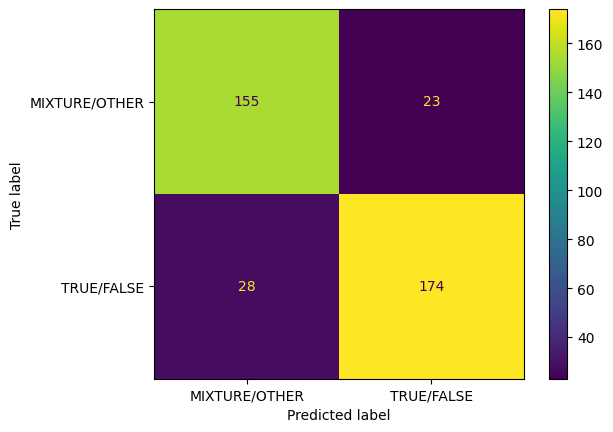

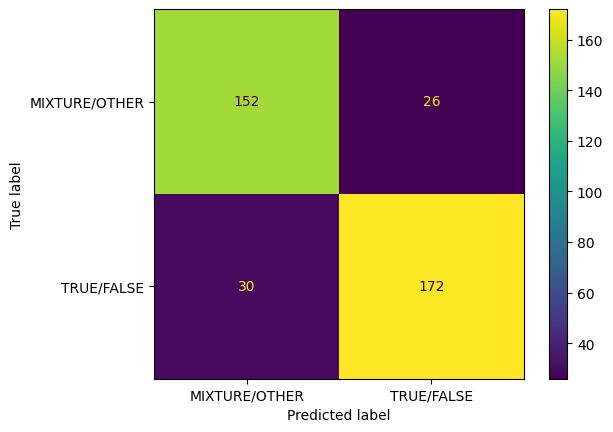

In [ ]:
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
import numpy as np
np.random.seed(42)  # Set the random seed for NumPy
print("y_train", y_train.shape)
print("y_test", y_test.shape)
#X_test = np.ravel(X_test)
print("X_test", X_test.shape)
# le plus simple est de faire un test sur differents pipelines.  


# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_title_SVC = []
X_test_title_SVC = []




for name, pipeline in all_models :
    X_train_title_SVC.append(pipeline.fit_transform(X_train['title']).toarray())
    X_test_title_SVC.append(pipeline.transform(X_test['title']).toarray())
   


models = {
    'SVC': SVC(random_state=42)
}
    

params = {'SVC': [{'C': [0.01, 0.1, 1,2]},
             {'gamma': [0.1,0.2,1]},
             {'kernel': ['linear', 'rbf']}]
}

for model_name, model in models.items():
    score='accuracy'
    X_train_title = eval('X_train_title_' + model_name)
    X_test_title = eval('X_test_title_' + model_name)
    for i in range (len(X_train_title)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train",X_train_title[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_title[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_title[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

###**Etape 3 : Classification selon la colonne TITRE :**

**Ici, c'est une étape importante,** on va tester différents classifieurs, pour chacun des classifieurs, on va appliquer le prétraitement + Vectorisation TfIdf, et on applique une cross_val_score avec un Kfold de 10 fois, par la suite on stocke dans une liste all_results la moyenne des accuracy + l'écart type et on la trie par ordre décroissant de moyenne d'accuracy et d'écart type. on remarque que les 2 meilleurs sont SVM et RF qu'on va séléctionner pour leur appliquer le GridSearch sur les paramètres des prétraitements + leurs hyperparamètres pour pouvoir choisir le meilleur.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import time

score = 'accuracy'
seed = 7
allresults = []
results = []
names = []


X_train_text=X_train['text']
X_train_text.reset_index(drop = True, inplace = True)


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

                        
# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))
    #pipeline.fit(X_train_text,y_train)
all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train_text,y_train, cv=kfold, scoring=score)
    #print("Pour le classifieur",p[0],"on a un score de",cv_results.mean(),"et un écart type de",cv_results.std())
    scores.append(cv_results)
    names.append(p[0])

    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))


Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC())])
all resultats [('SVM', 0.8756578947368421, 0.03078075675076207), ('RF', 0.8730263157894737, 0.030865010804578687), ('CART', 0.8546052631578946, 0.029925172146168837), ('LogisticRegression', 0.8217105263157896

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

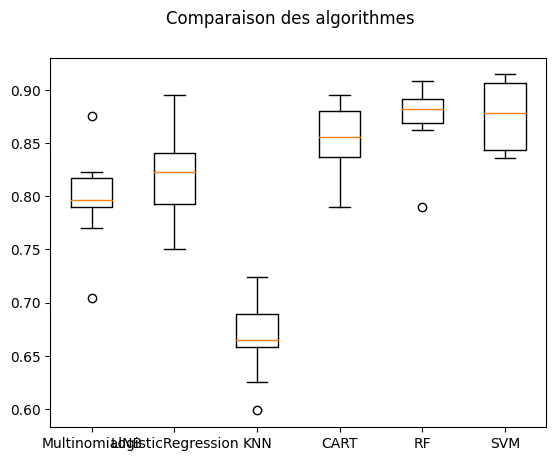

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

####Choisir les meilleurs paramètres pour SVM et RF :

On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

grid search fait
X_train_text (1520, 29370)
y_train (1520,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.855 

meilleur estimateur SVC(gamma=1, random_state=42) 

Accuracy : 0.884
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.86413   0.89326   0.87845       178
   TRUE/FALSE    0.90306   0.87624   0.88945       202

     accuracy                        0.88421       380
    macro avg    0.88360   0.88475   0.88395       380
 weighted avg    0.88483   0.88421   0.88430       380

Ensemble des meilleurs paramètres :
	C: 1.0
	gamma: 1
	kernel: 'rbf'
grid search fait
X_train_text (1520, 29228)
y_train (1520,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.857 

meilleur estimateur SVC(C=10, random_state=42) 

Accuracy : 0.903
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.89385   0.89888   0.89636       178
   TRUE/FALSE    0.910

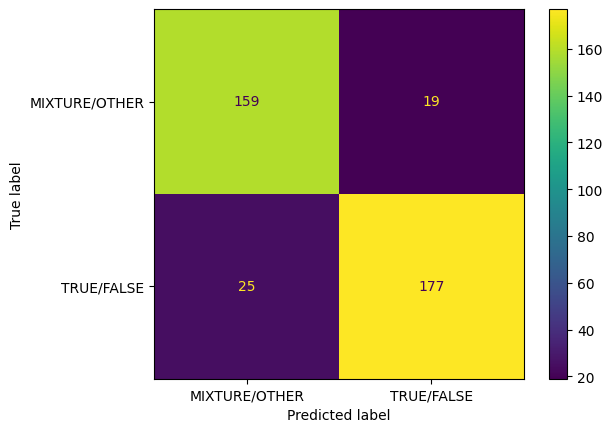

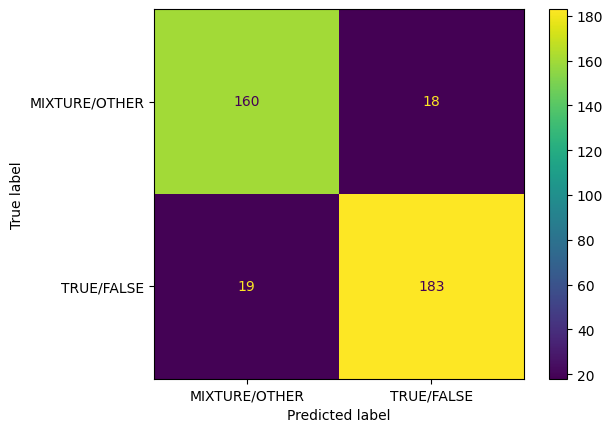

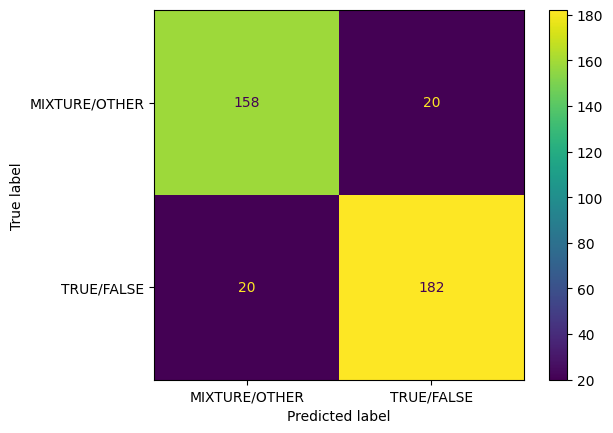

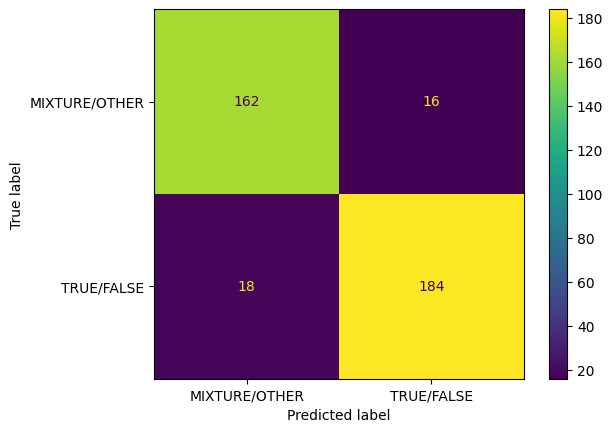

In [ ]:
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
import numpy as np

np.random.seed(42)  # Set the random seed for NumPy


# le plus simple est de faire un test sur differents pipelines.  

# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_text_SVC = []
X_test_text_SVC = []




for name, pipeline in all_models :
    X_train_text_SVC.append(pipeline.fit_transform(X_train['text']).toarray())
    X_test_text_SVC.append(pipeline.transform(X_test['text']).toarray())
    

models = {
    'SVC': SVC(random_state=42),
}
    

params = {'SVC': [{'C': [0.1, 1,10]},
             {'gamma': [0.001, 0.01, 0.1,1]},
             {'kernel': ['linear', 'rbf']}]
    
}

for model_name, model in models.items():
    score='accuracy'
    X_train_text = eval('X_train_text_' + model_name)
    X_test_text = eval('X_test_text_' + model_name)
    for i in range (len(X_train_text)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train_text",X_train_text[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_text[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_text[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

###**Etape 4 : Classification selon le TITRE ET TEXT ENSEMBLE (Concaténés):**

* On va à partir de X_train concaténer les 2 colonnes TEXT et TITLE en mettant un espace entre les deux 
* Vu qu'on va travailler sur la colonne text_titre qu'on vient de créer, on va séléctionner cette dernière depuis le X_train et X_test pour apprendre et tester après.

In [ ]:

#concaténation
X_train=X_train.apply(lambda row: ' '.join([str(val) for val in row]), axis=1)
X_test=X_test.apply(lambda row: ' '.join([str(val) for val in row]), axis=1)


**Ici, c'est une étape importante,** on va tester différents classifieurs, pour chacun des classifieurs, on va appliquer le prétraitement + Vectorisation TfIdf, et on applique une cross_val_score avec un Kfold de 10 fois, par la suite on stocke dans une liste all_results la moyenne des accuracy + l'écart type et on la trie par ordre décroissant de moyenne d'accuracy et d'écart type. on remarque que les 2 meilleurs sont SVM et RF qu'on va séléctionner pour leur appliquer le GridSearch sur les paramètres des prétraitements + leurs hyperparamètres pour pouvoir choisir le meilleur.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import time
import numpy as np



score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


#models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC(random_state=42)))

# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))

all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train,y_train, cv=kfold, scoring=score)
    scores.append(cv_results)
    names.append(p[0])
    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()


print("all resultats", all_results)

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))


Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC(random_state=42))])
all resultats [('MultinomialNB', 0.7914473684210526, 0.0461512102823568), ('LogisticRegression', 0.817763157894737, 0.042130954333119364), ('KNN', 0.67763157894736

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

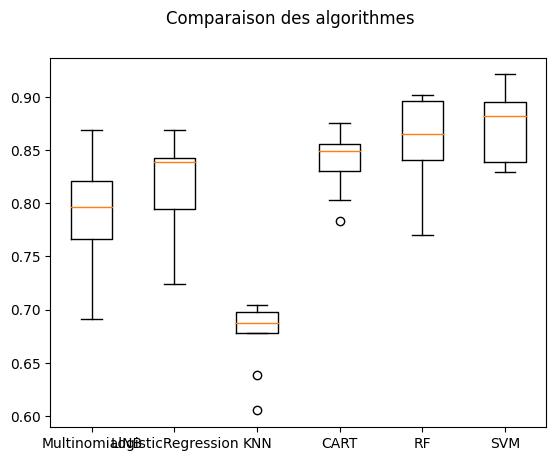

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

#### Choisir les meilleurs paramètres pour SVM et RF : 


On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

grid search fait
X_train_title_text (1520, 30034)
y_train (1520,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.857 

meilleur estimateur SVC(C=2, random_state=42) 

Accuracy : 0.892
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.88268   0.88764   0.88515       178
   TRUE/FALSE    0.90050   0.89604   0.89826       202

     accuracy                        0.89211       380
    macro avg    0.89159   0.89184   0.89171       380
 weighted avg    0.89215   0.89211   0.89212       380

Ensemble des meilleurs paramètres :
	C: 2
	gamma: 'scale'
	kernel: 'rbf'
grid search fait
X_train_title_text (1520, 29892)
y_train (1520,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.857 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.884
Classification Report
               precision    recall  f1-score   support

MIXTURE/OTHER    0.86022   0.89888   0.87912       178
   TRUE/F

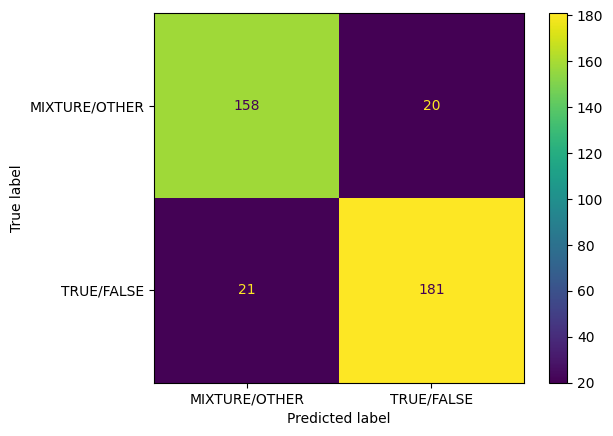

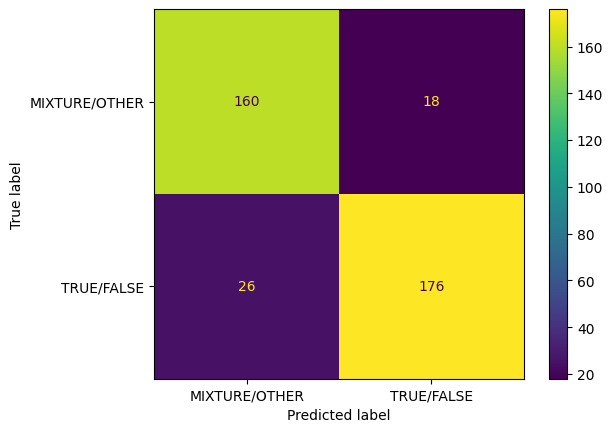

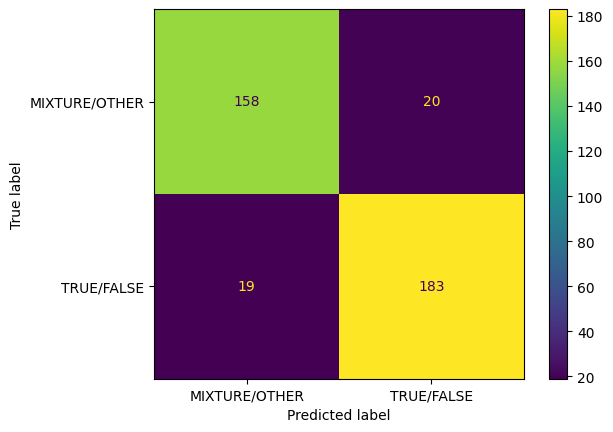

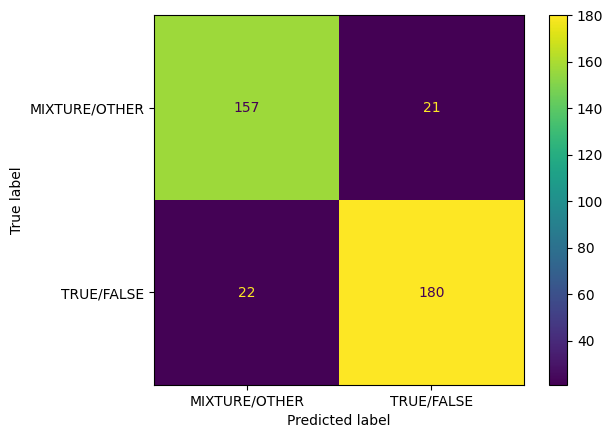

In [ ]:
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
import numpy as np
  

# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_title_text_SVC = []
X_test_title_text_SVC = []




for name, pipeline in all_models :
    X_train_title_text_SVC.append(pipeline.fit_transform(X_train).toarray())
    X_test_title_text_SVC.append(pipeline.transform(X_test).toarray())
    



models = {
    'SVC': SVC(random_state=42)
}
    

params = {'SVC': [{'C': [ 0.01, 0.1, 1,2]},
             {'gamma': [0.001, 0.01, 0.1,0.2]},
             {'kernel': ['linear', 'rbf']}]
}

for model_name, model in models.items():
    score='accuracy'
    X_train_title_text = eval('X_train_title_text_' + model_name)
    X_test_title_text = eval('X_test_title_text_' + model_name)
    for i in range (len(X_train_title_text)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train_title_text",X_train_title_text[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_title_text[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_title_text[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

##**Seconde classification sur Other vs mixture avec les données**


###**Etape 1 : Préparer les données**

On crée un nouveau dataframe avec que les lignes contenant dans la colonne rating les valeurs other et mixture

In [ ]:
dftrain = dftrainbase.loc[dftrainbase['rating'].isin(['other', 'mixture'])]
y=dftrain.iloc[0:,-1]
print("les valeurs de OTHER et MIXTURE maintenant sont " ,y.value_counts())

les valeurs de OTHER et MIXTURE maintenant sont  MIXTURE/OTHER    950
Name: regrouped, dtype: int64


Le jeu de données étant déséquilibré, on a pensé à appliquer le downsampling pour équilibrer nos données. on séléctionne des lignes aléatoirement de TRUE/FALSE de telle sorte que le nombre de lignes de TRUE/FALSE soit = au nbr de lignes de Other. et on mélange le DataFrame.

In [ ]:
# Compter le nombre d'observations dans chaque catégorie
mixture_count = dftrain['rating'].value_counts()['mixture']
other_count = dftrain['rating'].value_counts()['other']

# Trouver le nombre minimum d'observations parmi les catégories
min_count = min( mixture_count, other_count)

# Sous-échantillonner les catégories pour équilibrer les quantités
mixture_sampled = dftrain[dftrain['rating'] == 'mixture'].sample(min_count, random_state=42)
other_sampled = dftrain[dftrain['rating'] == 'other'].sample(min_count, random_state=42)


# Concaténer les échantillons pour obtenir un nouveau dataframe équilibré
dftrain = pd.concat([mixture_sampled,other_sampled])

# Mélanger aléatoirement les données
dftrain = dftrain.sample(frac=1, random_state=42)
print(dftrain)
X_text=dftrain["text"]
X_title=dftrain["title"]
y=dftrain.iloc[0:,-2]
print("\n")
print("la taille de y_train est " ,y.shape)
print("\n")
print("les valeurs de OTHER et MIXTURE maintenant sont " ,y.value_counts())

            id                                               text  \
2236  d190254d  For immediate release: For more information: J...   
2450  648e6bc4  Despite recent attempts to paint the United St...   
1802  8f40a510  RT America host Rick Sanchez has broken down t...   
2359  d462dc8d  A blitz on helping people with drink, drug and...   
1931  4107c249  From new funding to support veterans to reduci...   
...        ...                                                ...   
1887  11aea5b0  By Jim Francesconi As we pass the governance t...   
1940  347530a3  On Tuesday, radio show host John Fredricks sta...   
1837  073f3552  EXCLUSIVE: Third of cases won by terrorists, m...   
458   bfcfac7d  We all need to keep in mind that, except for a...   
817   9f4d9fd2  Aung San Suu Kyi Residence Rangoon, Burma 12:3...   

                                                  title   rating  \
2236  COVID-19: ''Abba Kyari Dead Of Coronavirus’ — ...  mixture   
2450  WHO: United States Among Leas

On divise notre grand X en jeu de données d'apprentissage et de test (20% de test).

In [ ]:

X=dftrain.iloc[0:, 1:3]
print(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=8)
print("X_train is",X_train)
print("y_train is",y_train)
print("X_test is",X_test)
print("y_test is",y_test)


                                                   text  \
2236  For immediate release: For more information: J...   
2450  Despite recent attempts to paint the United St...   
1802  RT America host Rick Sanchez has broken down t...   
2359  A blitz on helping people with drink, drug and...   
1931  From new funding to support veterans to reduci...   
...                                                 ...   
1887  By Jim Francesconi As we pass the governance t...   
1940  On Tuesday, radio show host John Fredricks sta...   
1837  EXCLUSIVE: Third of cases won by terrorists, m...   
458   We all need to keep in mind that, except for a...   
817   Aung San Suu Kyi Residence Rangoon, Burma 12:3...   

                                                  title  
2236  COVID-19: ''Abba Kyari Dead Of Coronavirus’ — ...  
2450  WHO: United States Among Least Polluting Natio...  
1802  Trump Won Two-Thirds of Election Lawsuits Wher...  
2359  Addicts and alcoholics cost us £10billion a ye...  
1

###**Etape 2 : Classification selon la colonne TITRE :**


Tester avec plusieurs classifieurs classiques.


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import time
import numpy as np

# Utilisez la méthode ravel() pour transformer y_train en un tableau unidimensionnel
#X_train = np.ravel(X_train)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
np.random.seed(42)  # Set the random seed for NumPy

score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC(random_state=42)))

# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))
    #pipeline.fit(X_train,y_train)
all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train['title'],y_train, cv=kfold, scoring=score)
    #print("Pour le classifieur",p[0],"on a un score de",cv_results.mean(),"et un écart type de",cv_results.std())
    scores.append(cv_results)
    names.append(p[0])

    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()


print("all resultats", all_results)

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))

X_train (374, 2)
y_train (374,)
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC(random_state=42))])
all resultats [('MultinomialNB', 0.7758179231863443, 0.0776154090711517), ('LogisticRegression', 0.8317211948790897, 0.054478382410

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

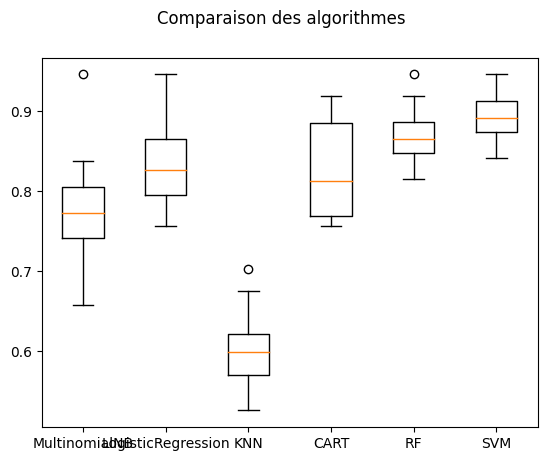

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

#### Choisir les meilleurs paramètres et hyperparamètres pour SVM


On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

y_train (374,)
y_test (94,)
X_test (94, 2)
grid search fait
X_train (374, 2564)
y_train (374,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.839 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.862
Classification Report
              precision    recall  f1-score   support

     mixture    0.78723   0.92500   0.85057        40
       other    0.93617   0.81481   0.87129        54

    accuracy                        0.86170        94
   macro avg    0.86170   0.86991   0.86093        94
weighted avg    0.87279   0.86170   0.86247        94

Ensemble des meilleurs paramètres :
	C: 1
	gamma: 'scale'
	kernel: 'rbf'
grid search fait
X_train (374, 2445)
y_train (374,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
meilleur score 0.837 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.851
Classification Report
              precision    recall  f1-score   support

     mixture    0.78261   0.90000   0.83721        40
    

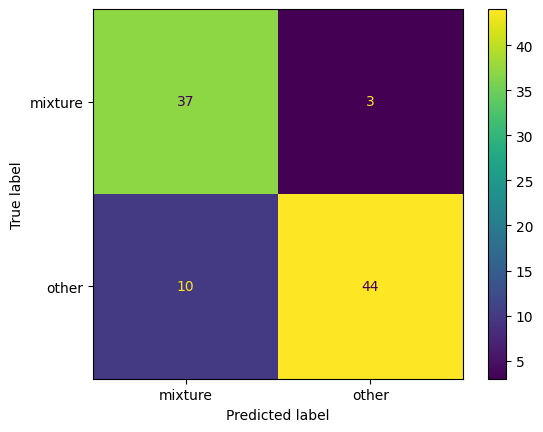

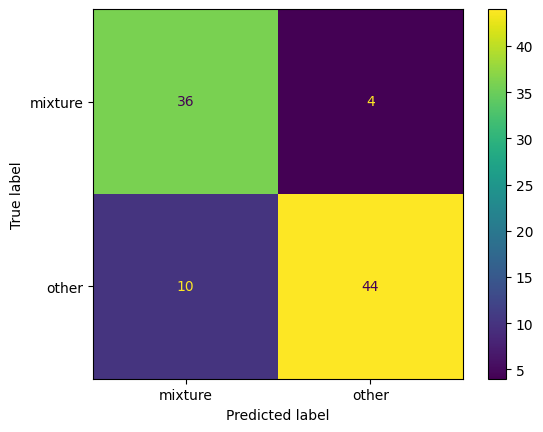

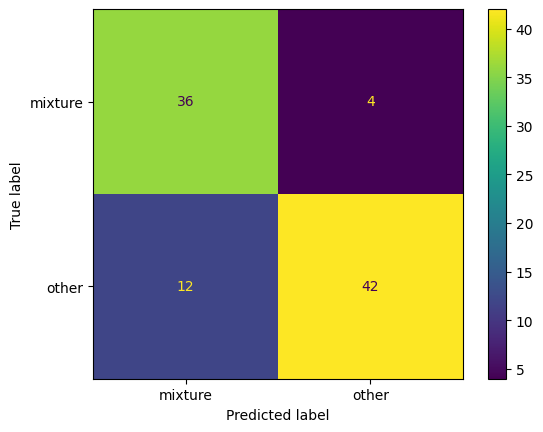

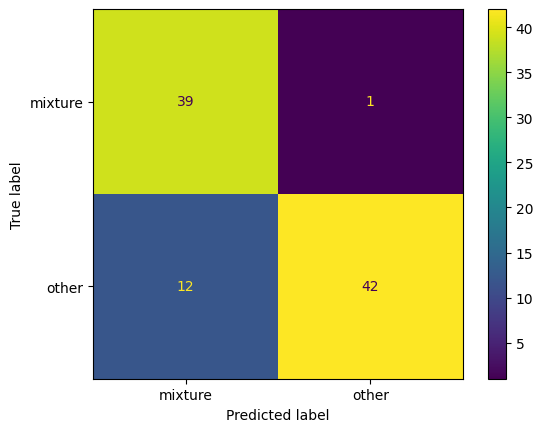

In [ ]:

np.random.seed(42)  # Set the random seed for NumPy
print("y_train", y_train.shape)
print("y_test", y_test.shape)
print("X_test", X_test.shape)
# le plus simple est de faire un test sur differents pipelines.  

# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_title_SVC = []
X_test_title_SVC = []



for name, pipeline in all_models :
    X_train_title_SVC.append(pipeline.fit_transform(X_train['title']).toarray())
    X_test_title_SVC.append(pipeline.transform(X_test['title']).toarray())
    



models = {
    'SVC': SVC(random_state=42)
}
    

params = {'SVC': [{'C': [ 0.1, 1,2]},
             {'gamma': [0.001, 0.01, 0.1,1]},
             {'kernel': ['linear', 'rbf']}]
}

for model_name, model in models.items():
    score='accuracy'
    X_train_title = eval('X_train_title_' + model_name)
    X_test_title = eval('X_test_title_' + model_name)
    for i in range (len(X_train_title)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train",X_train_title[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_title[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_title[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

###**Etape 3 : Classification selon la colonne TEXTE:**

**Ici, c'est une étape importante,** on va tester différents classifieurs, pour chacun des classifieurs, on va appliquer le prétraitement + Vectorisation TfIdf, et on applique une cross_val_score avec un Kfold de 10 fois, par la suite on stocke dans une liste all_results la moyenne des accuracy + l'écart type et on la trie par ordre décroissant de moyenne d'accuracy et d'écart type. on remarque que les 2 meilleurs sont SVM et RF qu'on va séléctionner pour leur appliquer le GridSearch sur les paramètres des prétraitements + leurs hyperparamètres pour pouvoir choisir le meilleur.

In [ ]:

score = 'accuracy'
seed = 7
allresults = []
results = []
names = []


X_train_text=X_train['text']
X_train_text.reset_index(drop = True, inplace = True)


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

                        
# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))
    #pipeline.fit(X_train_text,y_train)
all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train_text,y_train, cv=kfold, scoring=score)
    #print("Pour le classifieur",p[0],"on a un score de",cv_results.mean(),"et un écart type de",cv_results.std())
    scores.append(cv_results)
    names.append(p[0])

    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))


Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC())])
all resultats [('SVM', 0.8905405405405405, 0.034340991473749326), ('RF', 0.8583926031294453, 0.04770538077042521), ('LogisticRegression', 0.8288051209103839, 0.05796655874052694), ('MultinomialNB', 0.81600284

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

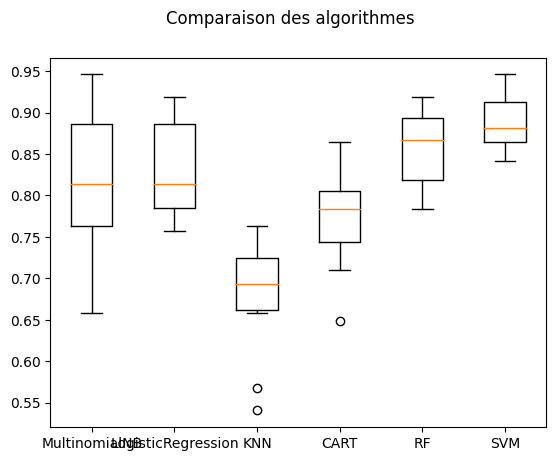

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

#### Choisir les meilleurs paramètres pour SVM et RF : 


On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

grid search fait
X_train (374, 15380)
y_train (374,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.855 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.840
Classification Report
              precision    recall  f1-score   support

     mixture    0.75510   0.92500   0.83146        40
       other    0.93333   0.77778   0.84848        54

    accuracy                        0.84043        94
   macro avg    0.84422   0.85139   0.83997        94
weighted avg    0.85749   0.84043   0.84124        94

Ensemble des meilleurs paramètres :
	C: 1
	gamma: 'scale'
	kernel: 'rbf'
grid search fait
X_train (374, 15242)
y_train (374,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.850 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.872
Classification Report
              precision    recall  f1-score   support

     mixture    0.79167   0.95000   0.86364        40
       other    0.95652   0.81481   0.88000

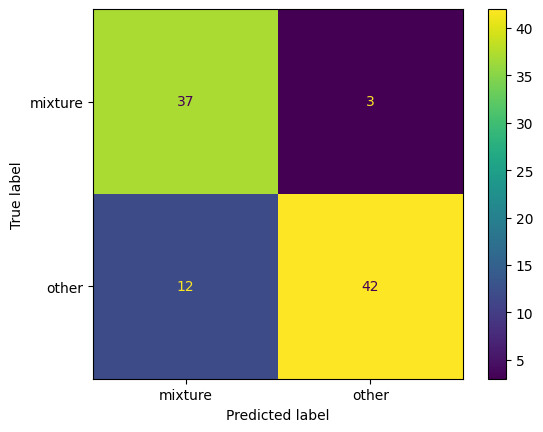

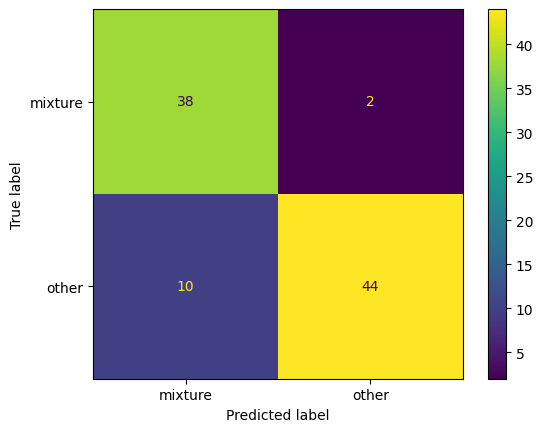

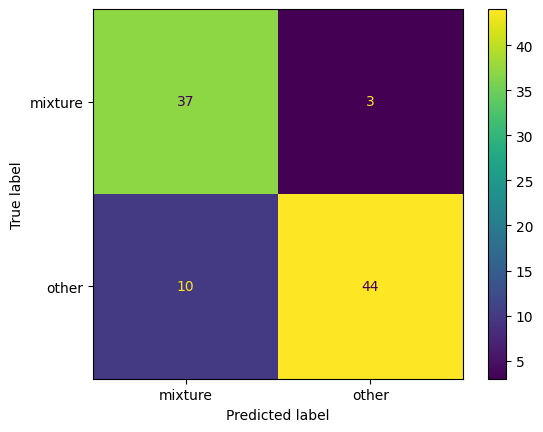

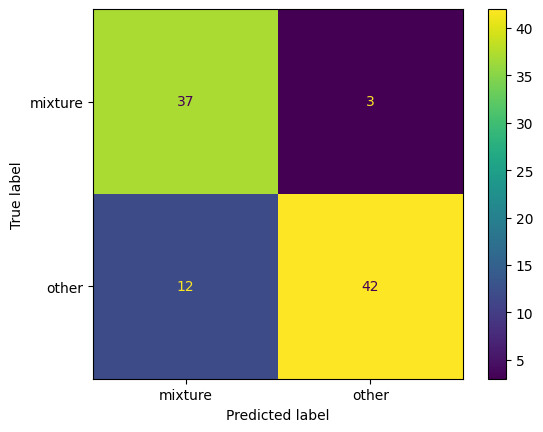

In [ ]:
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
import numpy as np




# le plus simple est de faire un test sur differents pipelines.  
# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_text_SVC = []
X_test_text_SVC = []



for name, pipeline in all_models :
    X_train_text_SVC.append(pipeline.fit_transform(X_train['text']).toarray())
    X_test_text_SVC.append(pipeline.transform(X_test['text']).toarray())
  




models = {
    'SVC': SVC(random_state=42)
}
    

params = {'SVC': [{'C': [0.01, 0.1, 1,2]},
             {'gamma': [0.01, 0.1,0.2,1]},
             {'kernel': ['linear', 'rbf']}]
}

for model_name, model in models.items():
    score='accuracy'
    X_train_text = eval('X_train_text_' + model_name)
    X_test_text = eval('X_test_text_' + model_name)
    for i in range (len(X_train_text)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train",X_train_text[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_text[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_text[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

###**Etape 4 : Classification selon le TITRE ET TEXT ENSEMBLE (Concaténés):**

* On va à partir de X_train concaténer les 2 colonnes TEXT et TITLE en mettant un espace entre les deux 
* Vu qu'on va travailler sur la colonne text_titre qu'on vient de créer, on va séléctionner cette dernière depuis le X_train et X_test pour apprendre et tester après.

In [ ]:

#concaténation
X_train=X_train.apply(lambda row: ' '.join([str(val) for val in row]), axis=1)
X_test=X_test.apply(lambda row: ' '.join([str(val) for val in row]), axis=1)


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import time
import numpy as np



score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []


# Liste des modèles à tester
models = [
    ('MultinomialNB', MultinomialNB()),
    ('LogisticRegression', LogisticRegression(random_state=42))
]


#models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC(random_state=42)))

# Création d'un pipeline pour chaque modèle
pipelines = []
for name,model in models:
    pipeline = Pipeline([
        ('normalize', TextNormalizer()),
        ('tfidf', TfidfVectorizer()),
        (name,model)
    ])
    pipelines.append((name,pipeline))

all_results=[]
scores=[]
for p in pipelines:
    print(p[1])
    # cross validation en 10 fois
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    
#    print ("Evaluation de ",p)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(p[1],X_train,y_train, cv=kfold, scoring=score)
    scores.append(cv_results)
    names.append(p[0])
    all_results.append((p[0],cv_results.mean(),cv_results.std()))
    end_time = time.time()


print("all resultats", all_results)

all_results = sorted(all_results, key=lambda x: (-x[1], -x[2]))
print("all resultats", all_results)
    # affichage des résultats
#print ('\nLe meilleur resultat : ',max(results))


Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier())])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('CART', DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier(random_state=42))])
Pipeline(steps=[('normalize', TextNormalizer()), ('tfidf', TfidfVectorizer()),
                ('SVM', SVC(random_state=42))])
all resultats [('MultinomialNB', 0.8105263157894737, 0.08495297157527221), ('LogisticRegression', 0.8233285917496443, 0.062043563685130185), ('KNN', 0.668349928876

On affiche les accuracy de chaque classifieur, on remarque la médiane (en rouge) de chaque et l'écart type aussi.

[Text(1, 0, 'MultinomialNB'),
 Text(2, 0, 'LogisticRegression'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'CART'),
 Text(5, 0, 'RF'),
 Text(6, 0, 'SVM')]

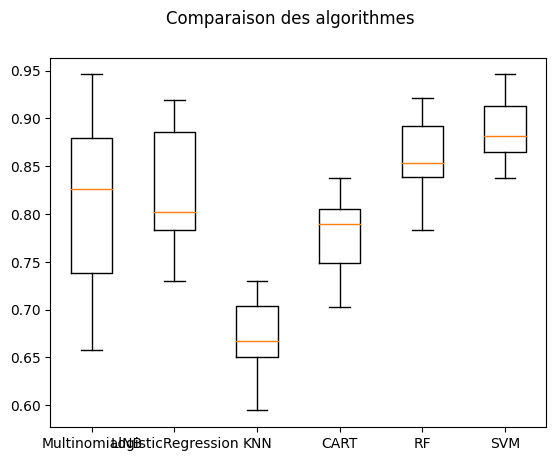

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

#### Choisir les meilleurs paramètres pour SVM et RF : 


On a un pipeline pour chaque prétraitement différent, on essaye pas mal (miniscule, lemmatisation, miniscule + lemmatisation..) et on stocke le fit_transorm de nos X_train, X_test sur les pipelines dans des listes qui vont contenir tous les fit_transform des pipelines pour chaque classifieur, par la suite on parcourt ces listes là, on itère dessus, et chaque élement de la liste (train) va passer par le GridSearch et puis on predict sur son corresapondant dans liste (test).

grid search fait
X_train_title_text (374, 15727)
y_train (374,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.850 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.851
Classification Report
              precision    recall  f1-score   support

     mixture    0.76000   0.95000   0.84444        40
       other    0.95455   0.77778   0.85714        54

    accuracy                        0.85106        94
   macro avg    0.85727   0.86389   0.85079        94
weighted avg    0.87176   0.85106   0.85174        94

Ensemble des meilleurs paramètres :
	C: 1
	gamma: 'scale'
	kernel: 'rbf'
grid search fait
X_train_title_text (374, 15589)
y_train (374,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
meilleur score 0.853 

meilleur estimateur SVC(C=1, random_state=42) 

Accuracy : 0.872
Classification Report
              precision    recall  f1-score   support

     mixture    0.79167   0.95000   0.86364        40
       other    0.956

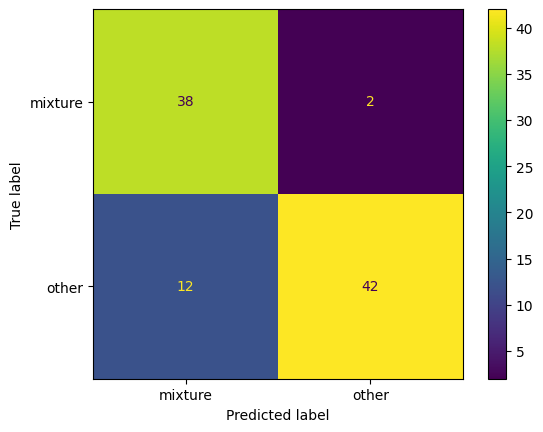

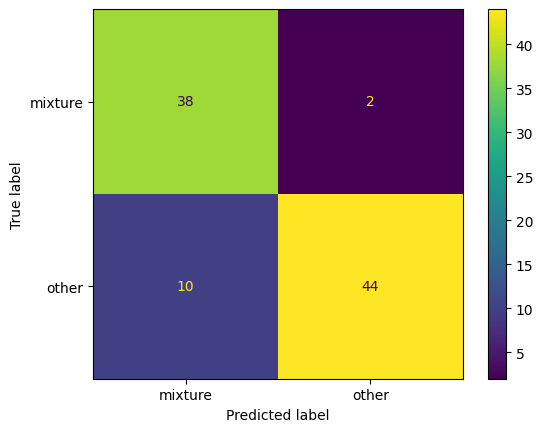

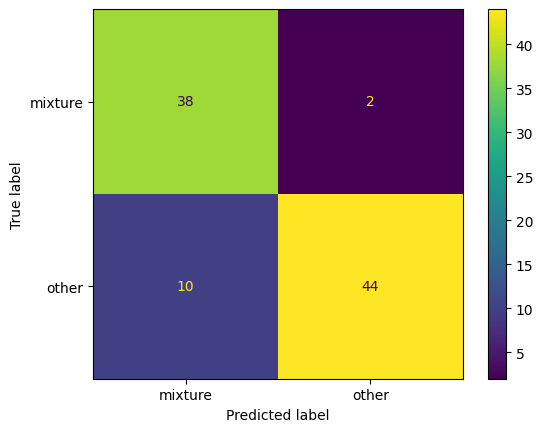

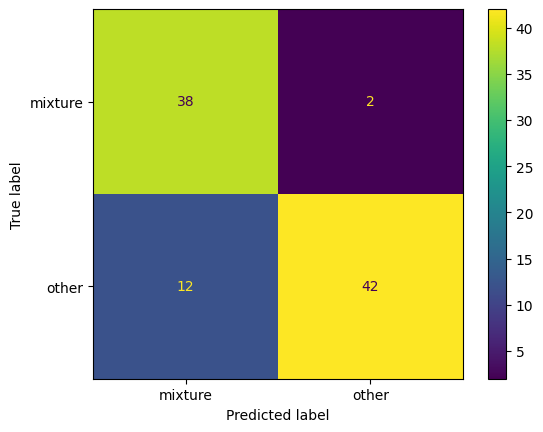

In [ ]:
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
import numpy as np
  


# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False))])


# Liste de tous les modeles à tester
all_models = [
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]

X_train_title_text_SVC = []
X_test_title_text_SVC = []




for name, pipeline in all_models :
    X_train_title_text_SVC.append(pipeline.fit_transform(X_train).toarray())
    X_test_title_text_SVC.append(pipeline.transform(X_test).toarray())
   



models = {
    'SVC': SVC(random_state=42)
}
    

params = {'SVC': [{'C': [0.01, 0.1, 1,2]},
             {'gamma': [0.001, 0.01, 0.1,1]},
             {'kernel': ['linear', 'rbf']}]
}

for model_name, model in models.items():
    score='accuracy'
    X_train_title_text = eval('X_train_title_text_' + model_name)
    X_test_title_text = eval('X_test_title_text_' + model_name)
    for i in range (len(X_train_title_text)):
      grid_search = GridSearchCV(model, params[model_name], n_jobs=-1,  verbose=1,scoring=score)
      print("grid search fait")
      print("X_train_title_text",X_train_title_text[i].shape)
      print("y_train",y_train.shape)
      grid_search.fit(X_train_title_text[i],y_train)
      print ('meilleur score %0.3f'%(grid_search.best_score_),'\n')
      print ('meilleur estimateur',grid_search.best_estimator_,'\n')
      y_pred = grid_search.predict(X_test_title_text[i])
      MyshowAllScores(y_test,y_pred)
      
      print("Ensemble des meilleurs paramètres :")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_dict in params[model_name]:
        for param_name, param_value in param_dict.items():
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

Classification de Other/Mixture avec les meilleurs prétraitements et meilleurs paramètres

In [ ]:
dftrain = dftrainbase.loc[dftrainbase['rating'].isin(['other', 'mixture'])]
y=dftrain.iloc[0:,-2]
print(y)
print("les valeurs de MIXTURE et OTHER maintenant sont " ,y.value_counts())

1       mixture
2       mixture
5         other
10      mixture
13      mixture
         ...   
2517    mixture
2518    mixture
2519    mixture
2520    mixture
2522      other
Name: rating, Length: 950, dtype: object
les valeurs de MIXTURE et OTHER maintenant sont  mixture    716
other      234
Name: rating, dtype: int64


In [ ]:
# Compter le nombre d'observations dans chaque catégorie
mixture_count = dftrain['rating'].value_counts()['mixture']
other_count = dftrain['rating'].value_counts()['other']

# Trouver le nombre minimum d'observations parmi les catégories
min_count = min( mixture_count, other_count)

# Sous-échantillonner les catégories pour équilibrer les quantités
mixture_sampled = dftrain[dftrain['rating'] == 'mixture'].sample(min_count, random_state=42)
other_sampled = dftrain[dftrain['rating'] == 'other'].sample(min_count, random_state=42)


# Concaténer les échantillons pour obtenir un nouveau dataframe équilibré
dftrain = pd.concat([mixture_sampled,other_sampled])

# Mélanger aléatoirement les données
dftrain = dftrain.sample(frac=1, random_state=42)
X_text=dftrain["text"]
X_title=dftrain["title"]
y=dftrain.iloc[0:,-2]
print("\n")
print("la taille de y_train est " ,y.shape)
print("\n")
print("les valeurs de OTHER et MIXTURE maintenant sont " ,y.value_counts())



la taille de y_train est  (468,)


les valeurs de OTHER et MIXTURE maintenant sont  mixture    234
other      234
Name: rating, dtype: int64


In [ ]:
X=dftrain["title"]
print(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=8)
print("X_train is",X_train)
print("y_train is",y_train)
print("X_test is",X_test)
print("y_test is",y_test)
y_test_2 = y_test


2236    COVID-19: ''Abba Kyari Dead Of Coronavirus’ — ...
2450    WHO: United States Among Least Polluting Natio...
1802    Trump Won Two-Thirds of Election Lawsuits Wher...
2359    Addicts and alcoholics cost us £10billion a ye...
1931    Electric Car-Owners Shocked: New Study Confirm...
                              ...                        
1887    DUP man dating Poots' daughter claims his 'tea...
1940                           Warren Statement on Boeing
1837                    European Court of Killers’ Rights
458     Almost 2,400 people declared 'fit to work' wer...
817                   Fighting Human Trafficking in Texas
Name: title, Length: 468, dtype: object
X_train is 1057    NHS Long Term Plan to tackle major killer cond...
440     Carbon dioxide didn't create climate crisis, s...
1290    Flynn campaign: Statement on Walker campaign a...
1137    52% of Americans would feel very comfortable w...
1518    Schools spending £1.3bn on supply teachers as ...
                     

In [ ]:
# création du pipeline en ajoutant le classifier
pipe = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ("SVM", SVC(C=2, gamma='scale', kernel='rbf', random_state=42))])

     
pipetexte=pipe.fit(X_train,y_train)
print("à présent",y)

#save pipe
print("pipeline créé")

à présent 2236    mixture
2450    mixture
1802    mixture
2359      other
1931    mixture
         ...   
1887    mixture
1940      other
1837      other
458       other
817     mixture
Name: rating, Length: 468, dtype: object
pipeline créé


Résultats de la classification selon Mixture et Other

208     European royals killing naked children for fun...
2245    Joe Biden Is Aiming To End The Federal Use Of ...
263     Biden Has Been Given Debate Questions in Advan...
2081                  Fighting Human Trafficking in Texas
1046    DUP man dating Poots' daughter claims his 'tea...
                              ...                        
1995    Private firms given £9.2bn of NHS budget despi...
768     Billionaire Jeffrey Epstein arrested and accus...
941                                   A 62% Top Tax Rate?
2385    London's most miserable boroughs revealed to b...
1269    K A B O O M! Governor and Secretary of State i...
Name: title, Length: 94, dtype: object
Accuracy : 0.883
Classification Report
              precision    recall  f1-score   support

     mixture    0.82222   0.92500   0.87059        40
       other    0.93878   0.85185   0.89320        54

    accuracy                        0.88298        94
   macro avg    0.88050   0.88843   0.88190        94
weighted avg

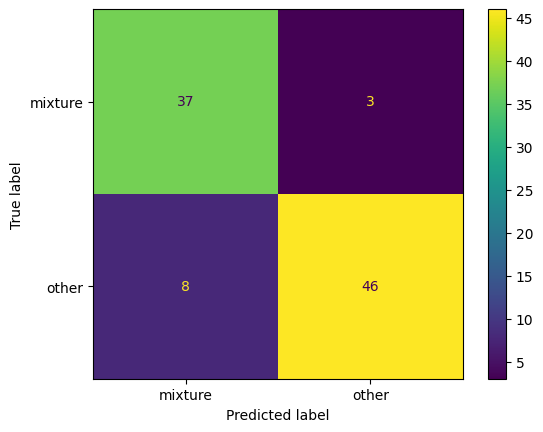

In [ ]:
X_test_text=X_test
print(X_test_text)
y_pred_2=pipetexte.predict(X_test_text)
MyshowAllScores(y_test,y_pred_2)


##**Classification sur True vs False**

In [ ]:
dftrain = dftrainbase.loc[dftrainbase['rating'].isin(['TRUE', 'FALSE'])]
y=dftrain.iloc[0:,-2]
print("les valeurs de TRUE et FALSE maintenant sont " ,y.value_counts())

les valeurs de TRUE et FALSE maintenant sont  FALSE    1156
TRUE      422
Name: rating, dtype: int64


In [ ]:
# Compter le nombre d'observations dans chaque catégorie
df_true = dftrain[dftrain['rating']=="TRUE"]
df_false = dftrain[dftrain['rating']=="FALSE"]

# Sous-échantillonner la classe majoritaire (FALSE) pour obtenir un nombre égal d'échantillons pour chaque classe
df_false_subsampled = df_false.sample(n=len(df_true), random_state=42)

# Concaténer les deux dataframes
dftrain = pd.concat([df_false_subsampled, df_true])

# Mélanger aléatoirement les données
dftrain = dftrain.sample(frac=1, random_state=42)



X_text=dftrain["text"]
X_title=dftrain["title"]
print("La taille de X_text",X_text.shape)
y=dftrain.iloc[0:,-2]
print(y)
print("\n")
print("la taille de y est " ,y.shape)
print("\n")
print("les valeurs de TRUE et FALSE maintenant sont " ,y.value_counts())


La taille de X_text (844,)
615      TRUE
1303    FALSE
1232     TRUE
2022     TRUE
287     FALSE
        ...  
1006    FALSE
1543    FALSE
853     FALSE
296      TRUE
1325    FALSE
Name: rating, Length: 844, dtype: object


la taille de y est  (844,)


les valeurs de TRUE et FALSE maintenant sont  TRUE     422
FALSE    422
Name: rating, dtype: int64


In [ ]:

X=dftrain.iloc[0:, 1:3]
print(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=8)
print("X_train is",X_train)
print("y_train is",y_train)
print("X_test is",X_test)
print("y_test is",y_test)
y_test_1=y_test

                                                   text  \
615   It’s been a long time coming, but finally we h...   
1303  Constitutional Attorney Matthew DePerno is an ...   
1232  The United States is witnessing a massive, dan...   
2022  After three decades on the bench, Sarah Parker...   
287   Based on actual results and accounting for sta...   
...                                                 ...   
1006  5 Million Muslim Children In Yemen Died due to...   
1543  The bombshell claim comes from over 20 hours o...   
853   BILL GATES EXPLAINS THAT THE COVID VACCINE WIL...   
296   Let our journalists help you make sense of the...   
1325  Though the whole world relies on RT-PCR to “di...   

                                                  title  
615   JK Rowling Confirms Stance Against Transgender...  
1303  MI Sec of State Official Caught On Video Telli...  
1232  What science can tell us about the links betwe...  
2022        Sarah Parker leaves legacy on Supreme Court  
2

In [ ]:
# création du pipeline en ajoutant le classifier
pipe = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ("SVM", SVC(C=2, gamma='scale', kernel='rbf', random_state=42))])
pipetexte=pipe.fit(X_train["text"],y_train)
print("à présent",y_train)

#save pipe
print("pipeline créé")

à présent 1867     TRUE
1540    FALSE
2495     TRUE
1197     TRUE
788      TRUE
        ...  
2224     TRUE
2424     TRUE
2038     TRUE
1295     TRUE
1890     TRUE
Name: rating, Length: 675, dtype: object
pipeline créé


Résultats de la classification selon True et False

360     Then-Secretary of State Hillary Clinton respon...
1216    Story highlights Global sea level is on the ri...
2466    Australia’s Great Barrier Reef has worst coral...
1757    News| [email protected] “If you won’t lead, th...
1387    For once, it’s not President Trump making head...
                              ...                        
2435    The oldest and thickest sea ice in the Arctic ...
523     A coalition of civil society groups has descri...
2127    A coalition of civil society groups has descri...
247     With merchants in Democrat-run cities boarding...
615     It’s been a long time coming, but finally we h...
Name: text, Length: 169, dtype: object
Accuracy : 0.923
Classification Report
              precision    recall  f1-score   support

       FALSE    0.90698   0.93976   0.92308        83
        TRUE    0.93976   0.90698   0.92308        86

    accuracy                        0.92308       169
   macro avg    0.92337   0.92337   0.92308       169
weighted avg

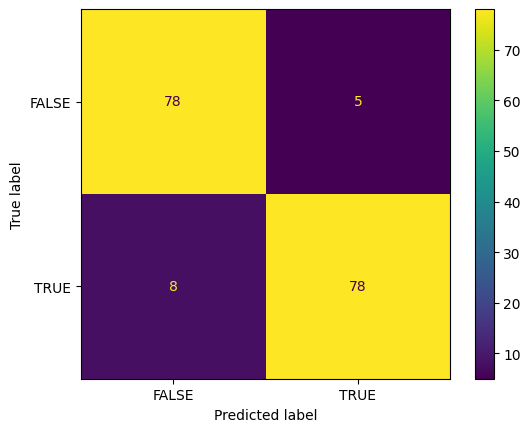

In [ ]:
X_test_text=X_test['text']
print(X_test_text)
y_pred_1=pipetexte.predict(X_test_text)
MyshowAllScores(y_test,y_pred_1)

##**Concaténons les résultats des deux classifications**

Accuracy : 0.909
Classification Report
              precision    recall  f1-score   support

       FALSE    0.90698   0.93976   0.92308        83
        TRUE    0.93976   0.90698   0.92308        86
     mixture    0.82222   0.92500   0.87059        40
       other    0.93878   0.85185   0.89320        54

    accuracy                        0.90875       263
   macro avg    0.90193   0.90590   0.90249       263
weighted avg    0.91134   0.90875   0.90896       263



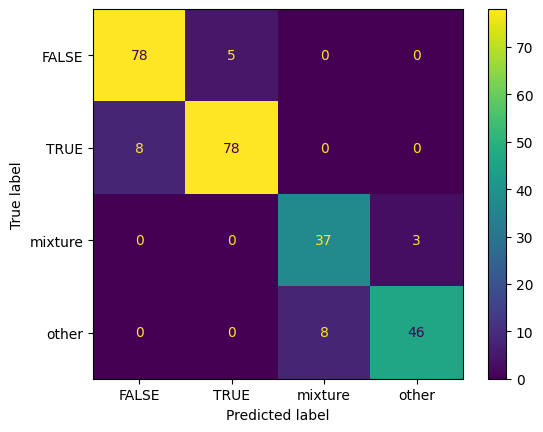

In [ ]:
# Conversion de tableaux NumPy en objets Series Pandas
y_pred_1 = pd.Series(y_pred_1)
y_pred_2 = pd.Series(y_pred_2)
#concat
y_pred_final = pd.concat([y_pred_1, y_pred_2], ignore_index=True)
y_test_final = pd.concat([y_test_1, y_test_2], ignore_index=True)
#dernier test
MyshowAllScores(y_test_final,y_pred_final) 